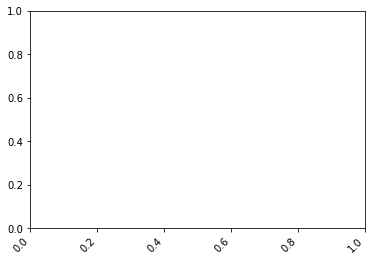

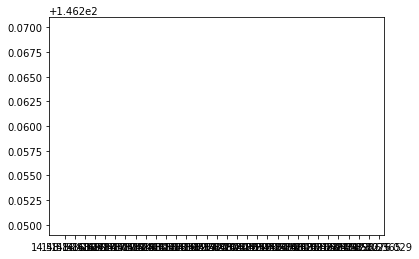

In [1]:
#!/usr/bin/env python3
# coding: utf-8

import sys
import subprocess

import blpapi
from xbbg import blp

import asyncio
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from datetime import datetime

# A directory for files that are not tracked by git, to which we'll download data
TMP_DIR = '../tmp/'
EXPORT_FILENAME = 'streaming_data.json'

# The maximum number of records we want to download before closing our connection
MAX_RECORDS = 1000
MAX_LIST = 100
MIN_TO_VIZ = 100

# The tickers and fields for which we want to stream live data
LIVE_PARAMS = {
    'tickers' : [
        'AAPL US Equity'
        ],
    'flds' : [
        'BID',
        'BID_UPDATE_STAMP_RT',
        'ASK',
        'ASK_UPDATE_STAMP_RT',
        'LAST_PRICE',
        'TRADE_UPDATE_STAMP_RT',
        'EVT_TRADE_DATE_RT'
        ]
}


async def get_ticks(settings: dict = LIVE_PARAMS, max: int = MAX_RECORDS, print_ticks: bool = True, download_path: str = TMP_DIR+EXPORT_FILENAME, download_ticks: bool = False):
    r"""
    Stream "live" data from the Bloomberg API. The live data for Education licenses is delayed by 15 minutes.

    :param settings: A dictionary with parameters for xbbg's blp.live() function, with keys matching the parameters of blp.live()
    :type settings: dict 
    :param max: Maximum number of records to stream before breaking async loop
    :type max: int 
    :param print_ticks: True to print streaming data (as json objects) to stdout, False otherwise
    :type print_ticks: bool 
    :param download_ticks: True to download streaming data, False otherwise
    :type print_ticks: bool
    """

    with open(download_path, 'w') as file:
        file.write('{"TICKS":[\n')

    count = 0
    async for tick in blp.live(**settings):
        try:
            if print_ticks:
                print(json.dumps(tick, indent=4, default=str))
            if download_ticks:
                if count >= (max-1):
                    line = json.dumps(tick, default=str) + '\n'
                else:
                    line = json.dumps(tick, default=str) + ',\n'

                with open(download_path, 'a') as file:
                    file.write(line)
        except:
            if print_ticks:
                print(tick)

        count += 1
        if count >= max:
            with open(download_path, 'a') as file:
                file.write(']}')
            break


async def viz_ticks(settings: dict = LIVE_PARAMS, max: int = MAX_RECORDS):
    r"""
    Populate small graph with streaming "live" tick data from the Bloomberg API. The live data for Education licenses is delayed by 15 minutes.

    :param settings: A dictionary with parameters for xbbg's blp.live() function, with keys matching the parameters of blp.live()
    :type settings: dict 
    :param max: Maximum number of records to stream before breaking async loop
    :type max: int
    """

    bid = []
    ask = []
    trd = []

    count = 0
    async for tick in blp.live(**settings):
        
        ticker = tick['TICKER'].split()[0]
        event_type = tick['MKTDATA_EVENT_TYPE']
        event_subtype = tick['MKTDATA_EVENT_SUBTYPE']

        if event_type == 'QUOTE' and event_subtype == 'BID':
            record = {
                'ticker': ticker,
                'timestamp': tick['BID_UPDATE_STAMP_RT'],
                'usd': tick['BID']
            }
            bid.append(record)
            if len(bid) > MAX_LIST:
                bid.pop(0)
        elif event_type == 'QUOTE' and event_subtype == 'ASK':
            record = {
                'ticker': ticker,
                'timestamp': tick['ASK_UPDATE_STAMP_RT'],
                'usd': tick['ASK']
            }
            ask.append(record)
            if len(ask) > MAX_LIST:
                ask.pop(0)
        elif event_type == 'TRADE' and event_subtype == 'NEW':
            record = {
                'ticker': ticker,
                'timestamp': tick['TRADE_UPDATE_STAMP_RT'],
                'usd': tick['LAST_PRICE']
            }
            trd.append(record)
            if len(trd) > MAX_LIST:
                trd.pop(0)
        else:
            pass

        if count == MIN_TO_VIZ:

            data = pd.DataFrame(trd)
            xset = [datetime.strftime(ts,'%H:%M:%S.%f')[:-3] for ts in list(data['timestamp'])]
            yset = list(data['usd'])
            
            plt.ion()
            plt.xticks(rotation=45, ha='right')
            fig = plt.figure()
            axis = fig.add_subplot(111)
            graph, = axis.plot(xset, yset, 'r-')
            plt.show()

        elif count > MIN_TO_VIZ:

            data = pd.DataFrame(trd)
            xset = [datetime.strftime(ts,'%H:%M:%S.%f')[:-3] for ts in list(data['timestamp'])]
            yset = list(data['usd'])
            
            graph.set_xdata(xset)
            graph.set_ydata(yset)
            fig.canvas.draw()
            fig.canvas.flush_events()
            
        count += 1
        if count >= max: break


if __name__ == "__main__":

    # Print and download streaming tick data, using the default maximum records and download path values
    await viz_ticks()